In [206]:
import copy
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
from typing import List
from cmap import Colormap
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

In [100]:
color_map = [
    "#FF0000",  # Red
    "#00FF00",  # Lime
    "#0000FF",  # Blue
    "#FFA500",  # Orange
    "#800080",  # Purple
    "#00FFFF",  # Cyan
    "#FF00FF",  # Magenta
    "#008000",  # Green
    "#FFC0CB",  # Pink
    "#8B4513",  # Saddle Brown
    "#FFD700",  # Gold
]

player_pos = ["P_1", "P_2", "P_3", "P_4", "P_5", "P_6", "P_7", "P_8", "P_9", "P_10", "P_11", "P_25", "P_15", "P_16", "P_17", "P_18", "P_19", "P_20", "P_21", "P_22", "P_23", "P_24"] # TODO: MIGHT BE FIX THIS LATER

In [101]:
df_home = pd.read_csv("Sample_Game_2_RawTrackingData_Home_Team.csv", low_memory=False)
df_away = pd.read_csv("Sample_Game_2_RawTrackingData_Away_Team.csv", low_memory=False)

In [102]:
ball_x = pd.to_numeric(df_home["Unnamed: 31"], errors='coerce')
ball_y = pd.to_numeric(df_home["Unnamed: 32"], errors='coerce')

In [103]:
df_home = df_home.iloc[2:].reset_index()
df_home = df_home.drop(columns=["index"])
columns_to_drop = df_home.columns[df_home.iloc[0].isna()]
df_home = df_home.drop(columns=columns_to_drop)

In [104]:
df_home.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Home,Unnamed: 4,Home.1,Unnamed: 6,Home.2,Unnamed: 8,Home.3,...,Home.6,Unnamed: 16,Home.7,Unnamed: 18,Home.8,Unnamed: 20,Home.9,Unnamed: 22,Home.10,Unnamed: 24
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [105]:
df_away = df_away.iloc[2:].reset_index()
df_away = df_away.drop(columns=["index"])
columns_to_drop = df_away.columns[df_away.iloc[0].isna()]
df_away = df_away.drop(columns=columns_to_drop)

In [106]:
df_away.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Away,Unnamed: 4,Away.1,Unnamed: 6,Away.2,Unnamed: 8,Away.3,...,Away.6,Unnamed: 16,Away.7,Unnamed: 18,Away.8,Unnamed: 20,Away.9,Unnamed: 22,Away.10,Unnamed: 24
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234


In [107]:
def add_headers(data: pd.DataFrame, team: str, start: int, end: int) -> list[str]:
    headers = []
    
    if team == "Home":
        headers.extend([f"{team}-P_1-x", f"{team}-P_1-y"])
    
    for i in range(start, end):
        player_index = i - start + (1 if team == "Home" else 11)
        
        headers.append(f"{team}-{player_pos[player_index]}-x")
        headers.append(f"{team}-{player_pos[player_index]}-y")

    headers = ["Period", "Frame", "Time[s]"] + headers
    return headers

df_home.columns = add_headers(df_home, "Home", 2, 12)
df_away.columns = add_headers(df_away, "Away", 12, 23)

In [108]:
df_home.head()

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_7-x,Home-P_7-y,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.58508,0.53017,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413


In [109]:
df_away.head()

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_20-x,Away-P_20-y,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234


## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [207]:
df_home['Period'] = pd.to_numeric(df_home['Period'], errors='coerce')
df_home["ball-x"], df_home["ball-y"] = ball_x, ball_y
period_1_data_home = df_home[df_home["Period"] == 1]

In [208]:
df_away['Period'] = pd.to_numeric(df_away['Period'], errors='coerce')
df_away["ball-x"], df_away["ball-y"] = ball_x, ball_y
period_1_data_away = df_away[df_away["Period"] == 1]

In [209]:
period_1_data_home.head()

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,NaN,NaN


In [210]:
period_1_data_away.head()

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN


In [211]:
def fill_nan_with_adjacent_average(data: pd.DataFrame) -> pd.DataFrame:
    """
    Fill NaN values in a DataFrame with the average of previous and next non-NaN values.
    
    Parameters:
    df_home (pd.DataFrame): Input DataFrame
    
    Returns:
    pd.DataFrame: DataFrame with NaN values filled
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_filled = data.copy()
    
    # Iterate through each column
    for col in df_filled.columns:
        if pd.api.types.is_numeric_dtype(df_filled[col]):
            df_filled[col] = df_filled[col].interpolate(method="linear")
        df_filled[col] = df_filled[col].ffill().bfill()
    
    return df_filled

In [212]:
period_1_data_home = fill_nan_with_adjacent_average(period_1_data_home)
period_1_data_away = fill_nan_with_adjacent_average(period_1_data_away)

In [213]:
period_1_data_home

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,0.00883,0.47469
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,0.00883,0.47469
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,0.00883,0.47469
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,0.00883,0.47469


In [214]:
period_1_data_away

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.00095,0.55662,0.40104,0.91503,0.33494,0.79087,0.3298,...,0.4305,0.63162,0.33736,0.43011,0.52637,0.93788,0.46338,0.61444,0.00883,0.47469
67937,1,67938,2717.52,0.00075,0.55671,0.40104,0.91503,0.33552,0.79133,0.33011,...,0.43062,0.63247,0.33727,0.43065,0.52626,0.93879,0.46345,0.61528,0.00883,0.47469
67938,1,67939,2717.56,0.00063,0.55671,0.40104,0.91503,0.33631,0.79184,0.33046,...,0.43075,0.63337,0.33729,0.43166,0.52624,0.93940,0.4636,0.61612,0.00883,0.47469
67939,1,67940,2717.6,0.00063,0.55671,0.40104,0.91503,0.33781,0.79344,0.3309,...,0.43091,0.63441,0.33734,0.43225,0.52621,0.94018,0.46374,0.61695,0.00883,0.47469


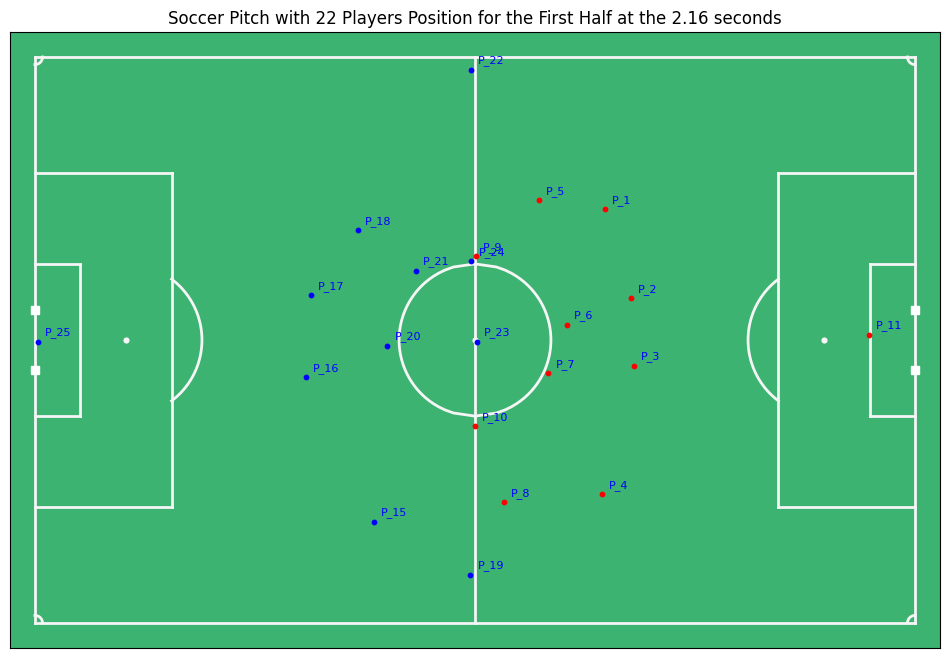

In [215]:
fig, ax = mviz.plot_pitch()

# Prepare player positions and their coordinates on the pitch
home_frame = period_1_data_home.iloc[53]
away_frame = period_1_data_away.iloc[53]
pos_x = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-x" in period_1_data_home.columns[i]]
pos_y = [[float(home_frame.iloc[i]), period_1_data_home.columns[i]] for i in range(3, period_1_data_home.shape[1] - 2) if "-y" in period_1_data_home.columns[i]]
pos_x = pos_x + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-x" in period_1_data_away.columns[i]]
pos_y = pos_y + [[float(away_frame.iloc[i]), period_1_data_away.columns[i]] for i in range(3, period_1_data_away.shape[1]) if "-y" in period_1_data_away.columns[i]]

data_x, col_x = [item[0] for item in pos_x], [item[1] for item in pos_x]
data_y, col_y = [item[0] for item in pos_y], [item[1] for item in pos_y]

positions_x = pd.DataFrame([data_x], columns=col_x)
positions_y = pd.DataFrame([data_y], columns=col_y)

# Changing the dataset to meter or pitch coordinates
positions_x = mio.to_metric_coordinates(positions_x)
positions_y = mio.to_metric_coordinates(positions_y)

MEAN_X_POS = positions_x.mean(axis=1)[0]
DIRECTION_TO_GOAL = "<--" if MEAN_X_POS > 0 else "-->"
DIRECTION_TO_GOAL += " Direction To Goal"

# Annotate player names
for i, (x, y, name) in enumerate(zip(positions_x.iloc[0], positions_y.iloc[0], player_pos)):
    color = "red"
    if i > 10:
        color = "blue"
    ax.scatter(x, y, color=color, s=10, zorder=2)  # Plot red dot
    ax.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points", fontsize=8, color='blue')
# ax.annotate(DIRECTION_TO_GOAL, (MEAN_X_POS, 29.55), xytext=(MEAN_X_POS, 29.55), textcoords="offset points", fontsize=18, color="red")

seconds = home_frame.iloc[2]
plt.title(f"Soccer Pitch with 22 Players Position for the First Half at the {seconds} seconds")
plt.show()

In [216]:
period_1_data_home

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Home-P_8-x,Home-P_8-y,Home-P_9-x,Home-P_9-y,Home-P_10-x,Home-P_10-y,Home-P_11-x,Home-P_11-y,ball-x,ball-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.53163,0.75084,0.50637,0.30137,0.50194,0.61123,0.94275,0.50413,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.51337,0.71683,0.52318,0.78966,0.54702,0.86195,0.51242,...,0.40066,0.50905,0.35073,0.59980,0.337,0.79222,0.81546,0.72958,0.00883,0.47469
67937,1,67938,2717.52,0.51339,0.71801,0.52312,0.79035,0.54692,0.86271,0.51242,...,0.40095,0.50993,0.35105,0.60026,0.33727,0.79263,0.81461,0.73064,0.00883,0.47469
67938,1,67939,2717.56,0.5134,0.71929,0.52312,0.79124,0.54677,0.86355,0.51242,...,0.40122,0.51062,0.35136,0.60081,0.33756,0.79303,0.81413,0.73124,0.00883,0.47469
67939,1,67940,2717.6,0.51342,0.72035,0.52315,0.79171,0.54673,0.86423,0.51242,...,0.40148,0.51078,0.35166,0.60165,0.33781,0.79344,0.81385,0.73124,0.00883,0.47469


In [217]:
period_1_data_away

,Period,Frame,Time[s],Away-P_25-x,Away-P_25-y,Away-P_15-x,Away-P_15-y,Away-P_16-x,Away-P_16-y,Away-P_17-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,2,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,3,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,4,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,5,0.2,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,67937,2717.48,0.00095,0.55662,0.40104,0.91503,0.33494,0.79087,0.3298,...,0.4305,0.63162,0.33736,0.43011,0.52637,0.93788,0.46338,0.61444,0.00883,0.47469
67937,1,67938,2717.52,0.00075,0.55671,0.40104,0.91503,0.33552,0.79133,0.33011,...,0.43062,0.63247,0.33727,0.43065,0.52626,0.93879,0.46345,0.61528,0.00883,0.47469
67938,1,67939,2717.56,0.00063,0.55671,0.40104,0.91503,0.33631,0.79184,0.33046,...,0.43075,0.63337,0.33729,0.43166,0.52624,0.93940,0.4636,0.61612,0.00883,0.47469
67939,1,67940,2717.6,0.00063,0.55671,0.40104,0.91503,0.33781,0.79344,0.3309,...,0.43091,0.63441,0.33734,0.43225,0.52621,0.94018,0.46374,0.61695,0.00883,0.47469


## Tracking for individual Players for the First Period

In [218]:
period_1_data = pd.concat([period_1_data_home.iloc[:3000, :-2],  period_1_data_away.iloc[:3000, 3:]], axis=1)

In [219]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,2996,119.84,0.34313,0.03982,0.52153,0.29063,0.55613,0.56865,0.49303,...,0.29977,0.42087,0.3408,0.10352,0.44295,0.26090,0.42858,0.40087,0.34522,0.04131
2996,1,2997,119.88,0.34243,0.03929,0.52063,0.28969,0.55554,0.56768,0.49214,...,0.29924,0.42081,0.33966,0.10262,0.44252,0.26050,0.42816,0.40084,0.34452,0.04082
2997,1,2998,119.92,0.34175,0.03885,0.5197,0.28882,0.55497,0.56665,0.49126,...,0.2987,0.42075,0.33851,0.10171,0.4421,0.26009,0.42774,0.40080,0.34382,0.04032
2998,1,2999,119.96,0.34108,0.03840,0.51875,0.28795,0.55438,0.56563,0.49037,...,0.29813,0.42057,0.33736,0.10089,0.44168,0.25968,0.42733,0.40076,0.34312,0.03980


In [357]:
def player_tracking(dataset: pd.DataFrame, players: list[int] = [11], plot_ball: bool =True, use_annotation: bool = False, sides: list[str] = None, markersize: int = 7):
    fig, ax = mviz.plot_pitch()
    ball_is_not_there = plot_ball
    title = "Player, and Side at each intervals"
    if use_annotation:
        title = "Player, and Frame at each intervals"
    
    for i, (player, side) in enumerate(zip(players, sides)):
        x = f"{side}-P_{player}-x"
        y = f"{side}-P_{player}-y"
    
        # Prepare player positions and their coordinates on the pitch
        data_x = pd.to_numeric(dataset[x], errors='coerce')
        data_y = pd.to_numeric(dataset[y], errors='coerce')
        
        # Create DataFrames with a single column for x and y coordinate of a player
        positions_x = pd.DataFrame(data_x, columns=[x])
        positions_y = pd.DataFrame(data_y, columns=[y])
        
        # Changing the dataset to metric or pitch coordinates
        positions_x = mio.to_metric_coordinates(positions_x)
        positions_y = mio.to_metric_coordinates(positions_y)

        color = color_map[i % len(color_map)]
        
        # Plot player movement with arrows
        for j in range(len(positions_x) - 1):
            dx = positions_x[x].iloc[j+1] - positions_x[x].iloc[j]
            dy = positions_y[y].iloc[j+1] - positions_y[y].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc=color, ec=color, linestyle="dotted", length_includes_head=True)

        # Plot the player path with dots and lines
        if use_annotation:
            for i in range(len(positions_x)):
                ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"{use_annotation[i]} - {positions_x.index[i]}")
                ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12, ha='right')
        else:
            ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=markersize, color=color, zorder=3, label=f"Player {player} - {side}")
        ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=3)
        ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=3)
                    
        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

    if ball_is_not_there:
        ba_x = pd.to_numeric(dataset["ball-x"], errors='coerce')
        ba_y = pd.to_numeric(dataset["ball-y"], errors='coerce')
        
        ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["ball-x"]))
        ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["ball-y"]))
        
        ax.plot(ba_x["ball-x"], ba_y["ball-y"], marker=".", linestyle="-.", markersize=int(markersize * 1.5), color="black", zorder=2, label="Ball")
        ax.plot(ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="green", zorder=2)
        ax.plot(ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1], marker=".", linestyle="-.", markersize=int(markersize * 1.75), color="red", zorder=2)
        
        # Ball movement arrows
        for j in range(len(ba_x) - 1):
            dx = ba_x["ball-x"].iloc[j+1] - ba_x["ball-x"].iloc[j]
            dy = ba_y["ball-y"].iloc[j+1] - ba_y["ball-y"].iloc[j]
            if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                ax.arrow(ba_x["ball-x"].iloc[j], ba_y["ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2, fc='black', ec='black', linestyle="dotted", length_includes_head=True)
                
        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        
    ball_is_not_there = False
    
    start_seconds = dataset["Time[s]"].iloc[0]
    end_seconds = dataset["Time[s]"].iloc[-1]
    pl = [i for i in players]
    ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")
    ax.legend(title=title, loc="upper left", fontsize=8)
        
    plt.tight_layout()
    plt.show()

In [221]:
# player_tracking(period_1_data_home)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [222]:
period_1_data

,Period,Frame,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,2,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,3,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,4,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,5,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,2996,119.84,0.34313,0.03982,0.52153,0.29063,0.55613,0.56865,0.49303,...,0.29977,0.42087,0.3408,0.10352,0.44295,0.26090,0.42858,0.40087,0.34522,0.04131
2996,1,2997,119.88,0.34243,0.03929,0.52063,0.28969,0.55554,0.56768,0.49214,...,0.29924,0.42081,0.33966,0.10262,0.44252,0.26050,0.42816,0.40084,0.34452,0.04082
2997,1,2998,119.92,0.34175,0.03885,0.5197,0.28882,0.55497,0.56665,0.49126,...,0.2987,0.42075,0.33851,0.10171,0.4421,0.26009,0.42774,0.40080,0.34382,0.04032
2998,1,2999,119.96,0.34108,0.03840,0.51875,0.28795,0.55438,0.56563,0.49037,...,0.29813,0.42057,0.33736,0.10089,0.44168,0.25968,0.42733,0.40076,0.34312,0.03980


In [223]:
period_1_data = period_1_data.drop(columns=["Frame"])

In [224]:
period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,0.2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,119.84,0.34313,0.03982,0.52153,0.29063,0.55613,0.56865,0.49303,0.67171,...,0.29977,0.42087,0.3408,0.10352,0.44295,0.26090,0.42858,0.40087,0.34522,0.04131
2996,1,119.88,0.34243,0.03929,0.52063,0.28969,0.55554,0.56768,0.49214,0.67111,...,0.29924,0.42081,0.33966,0.10262,0.44252,0.26050,0.42816,0.40084,0.34452,0.04082
2997,1,119.92,0.34175,0.03885,0.5197,0.28882,0.55497,0.56665,0.49126,0.67047,...,0.2987,0.42075,0.33851,0.10171,0.4421,0.26009,0.42774,0.40080,0.34382,0.04032
2998,1,119.96,0.34108,0.03840,0.51875,0.28795,0.55438,0.56563,0.49037,0.66984,...,0.29813,0.42057,0.33736,0.10089,0.44168,0.25968,0.42733,0.40076,0.34312,0.03980


In [241]:
# Convert all columns to numeric
temp_data = copy.deepcopy(period_1_data)
for col in temp_data.columns:
    if col != "Period" and col != "Time[s]":
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce')
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
    else:
        period_1_data[col] = pd.to_numeric(period_1_data[col], errors='coerce')
        temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce').astype(int)

avg_1_sec = pd.DataFrame()

# Calculate averages for each column
for col in temp_data.columns:
    averages = []
    for i in range(0, len(temp_data), 25):
        group = temp_data[col].iloc[i:i+25]
        avg = group.mean()
        averages.append(avg)
    
    # Add the averages for this column to avg_1_sec
    avg_1_sec[col] = averages   

# avg_1_sec.reset_index(drop=True, inplace=True)
avg_1_sec.index = range(1, len(avg_1_sec) + 1)

In [227]:
avg_1_sec = avg_1_sec.iloc[:100]
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1.0,0.04,0.647560,0.283644,0.677520,0.428030,0.696592,0.555645,0.644147,0.762736,...,0.432839,0.357528,0.497823,0.014630,0.501770,0.501450,0.495170,0.362340,0.502160,0.503760
2,1.0,1.04,0.647150,0.275018,0.677629,0.426852,0.686746,0.549754,0.644875,0.767359,...,0.432688,0.377177,0.495778,0.024554,0.501954,0.502422,0.495172,0.362320,0.502160,0.503760
3,1.0,2.04,0.649075,0.267862,0.677262,0.426183,0.676346,0.545278,0.643126,0.777459,...,0.434040,0.376211,0.495640,0.021007,0.502760,0.504104,0.497760,0.361457,0.475665,0.505001
4,1.0,3.04,0.650808,0.270631,0.675158,0.425478,0.665320,0.549432,0.641822,0.791985,...,0.439949,0.372589,0.504589,0.017182,0.511515,0.507609,0.511674,0.367192,0.415423,0.507907
5,1.0,4.04,0.651694,0.280151,0.676261,0.421896,0.657516,0.555598,0.646048,0.804760,...,0.454579,0.368341,0.529735,0.012959,0.534513,0.518531,0.539336,0.385298,0.411684,0.510197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,95.04,0.684736,0.347691,0.705132,0.574020,0.665660,0.796998,0.533835,0.991324,...,0.469611,0.830619,0.620249,0.513454,0.661462,0.415208,0.592110,0.820090,0.568900,0.926980
97,1.0,96.04,0.688511,0.359455,0.723160,0.610179,0.665004,0.853710,0.560912,0.988387,...,0.490528,0.845969,0.627039,0.527022,0.669124,0.444810,0.615717,0.850423,0.628956,0.854066
98,1.0,97.04,0.691733,0.361788,0.740839,0.634582,0.672151,0.896891,0.585750,0.973080,...,0.507897,0.858088,0.631694,0.543294,0.670372,0.478440,0.637200,0.843921,0.546167,0.923449
99,1.0,98.04,0.692347,0.360227,0.740757,0.642786,0.690913,0.911300,0.597130,0.961983,...,0.520422,0.861600,0.631526,0.561417,0.665106,0.507191,0.637781,0.829780,0.524474,0.944732


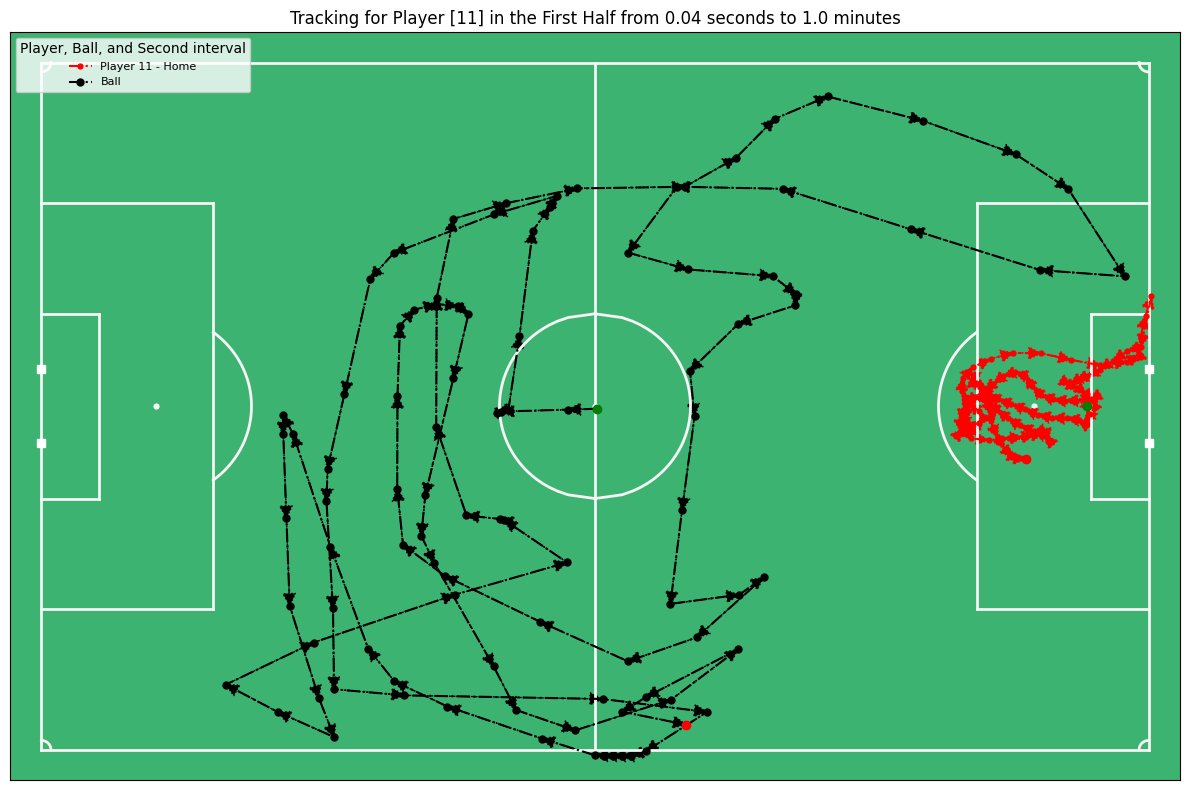

In [228]:
player_tracking(avg_1_sec.loc[:"Home-P_11-y"], plot_ball=True, sides=["Home"]*avg_1_sec.loc[:"Home-P_11-y"].shape[1])

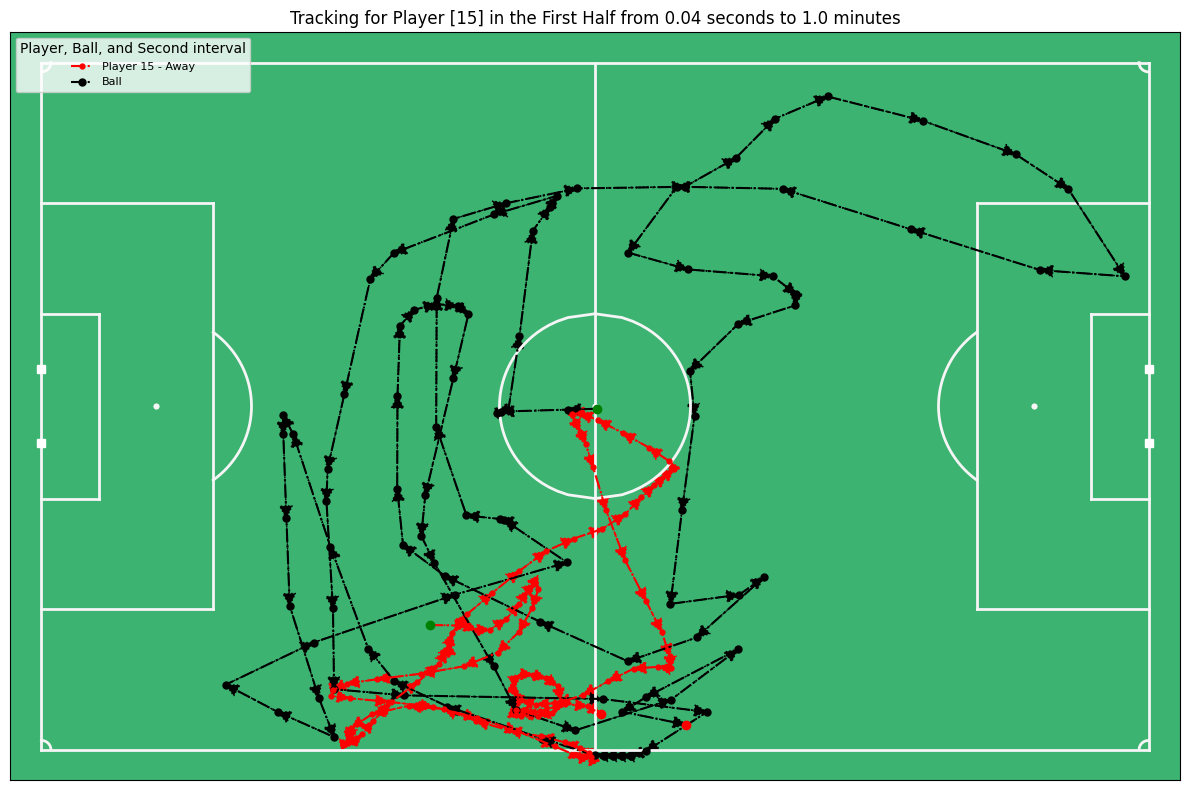

In [229]:
player_tracking(avg_1_sec, [15], sides=["Away"]*1)

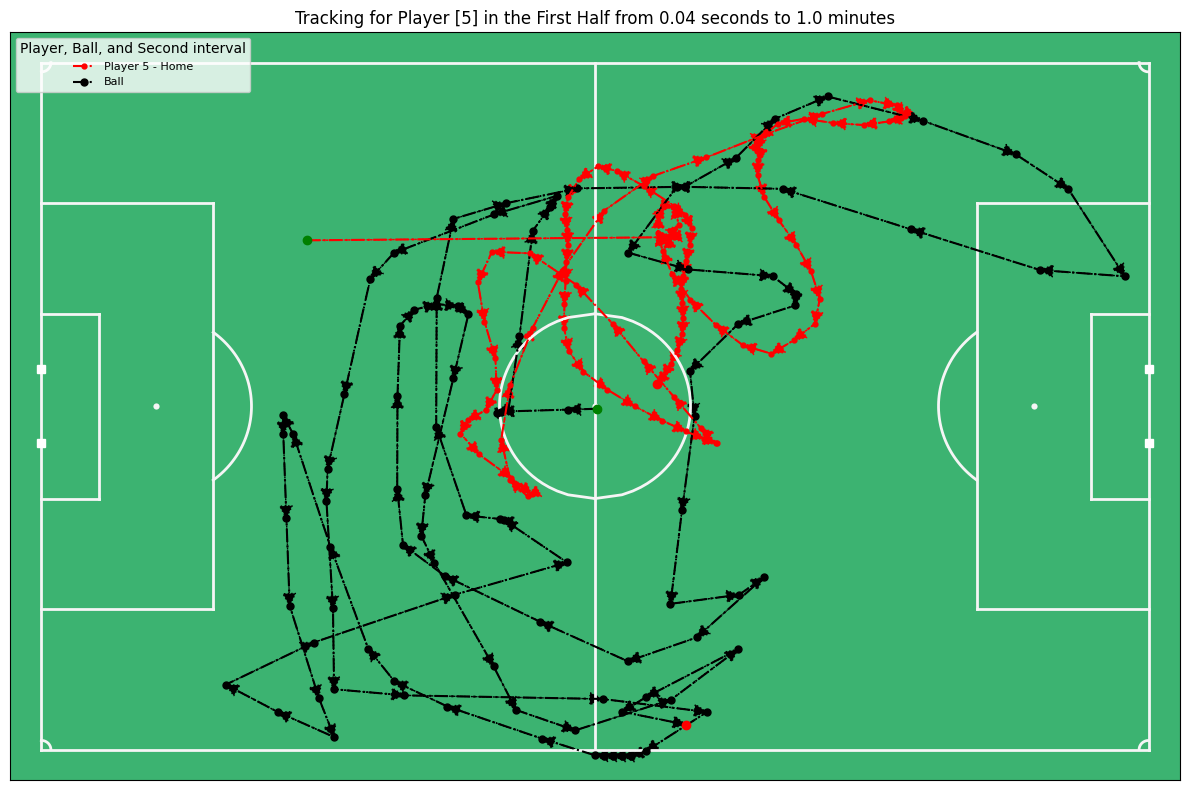

In [230]:
player_tracking(avg_1_sec, [5], sides=["Home"])

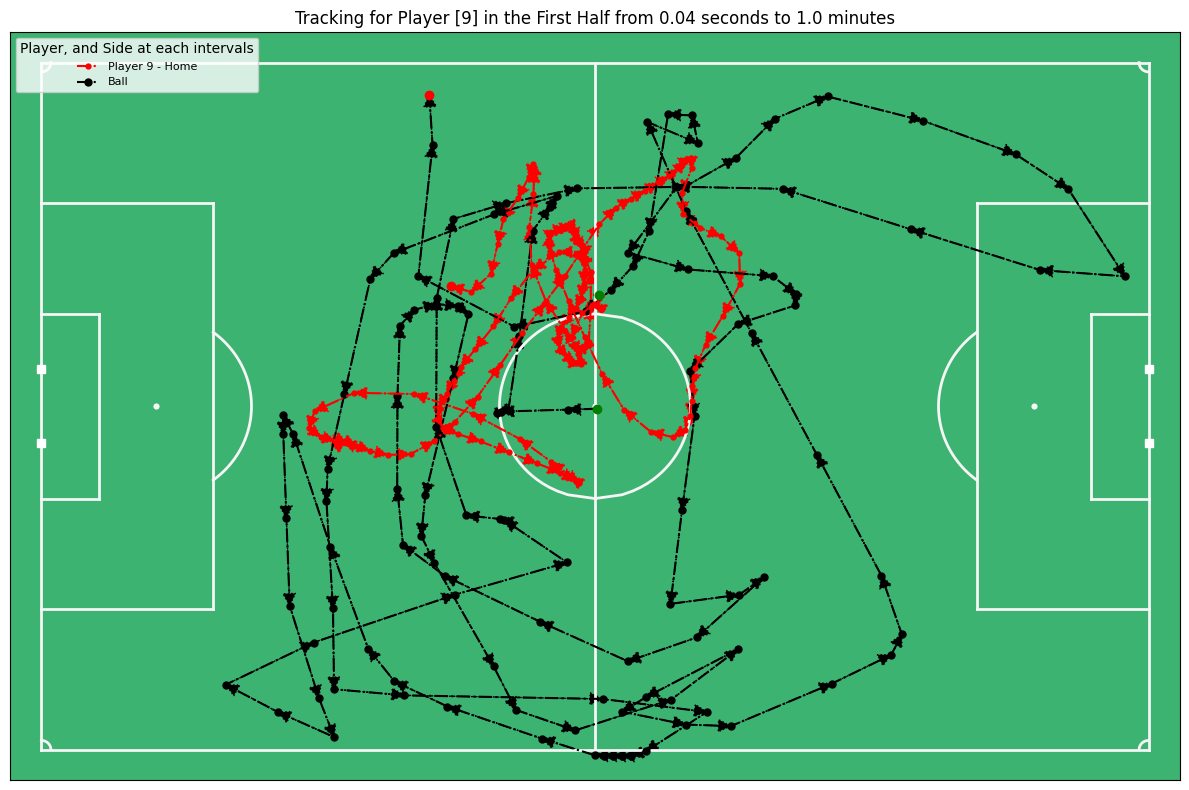

In [305]:
player_tracking(avg_1_sec, [9], sides=["Home"])

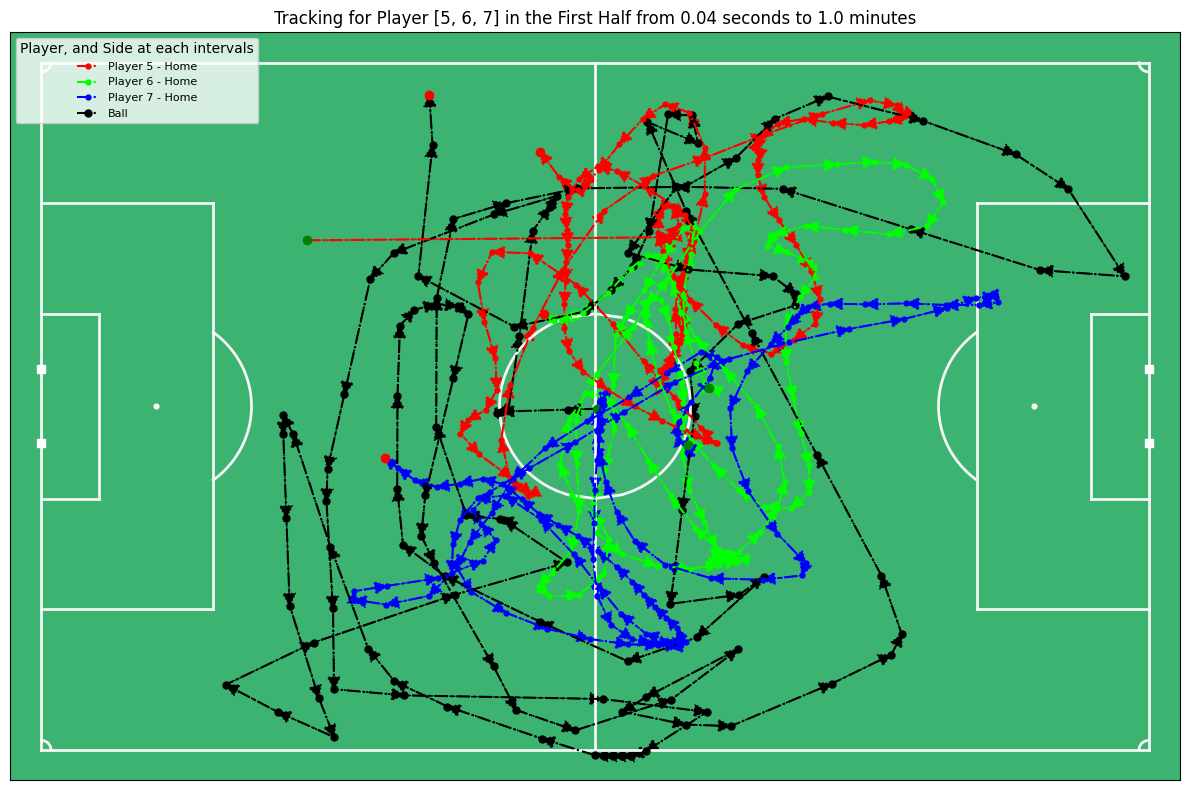

In [304]:
player_tracking(avg_1_sec, [5, 6, 7], sides=["Home"]*3)

In [233]:
# Calculate players speed
def players_speed():
    MPS_TO_MPH = 2.23694
    player_columns = [(f'P_{i}-x', f'P_{i}-y') for i in range(1, 12)]
    
    for i, (x_col, y_col) in enumerate(player_columns, 1):
        # Calculate Euclidean distance between consecutive points
        x_diff = avg_1_sec[x_col].diff()
        y_diff = avg_1_sec[y_col].diff()
        distance = np.sqrt(x_diff**2 + y_diff**2)
        
        # Calculate time difference between frames
        time_diff = avg_1_sec['Time[s]'].diff()
        
        # Calculate speed (distance / time)
        # Note: First row will be NaN as we can't calculate speed for a single point
        speed = distance / time_diff
        speed_mph = speed * MPS_TO_MPH
        
        avg_1_sec[f"P_{i}_speed"] = speed_mph

# players_speed()

In [234]:
avg_1_sec

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
1,1.0,0.04,0.647560,0.283644,0.677520,0.428030,0.696592,0.555645,0.644147,0.762736,...,0.432839,0.357528,0.497823,0.014630,0.501770,0.501450,0.495170,0.362340,0.502160,0.503760
2,1.0,1.04,0.647150,0.275018,0.677629,0.426852,0.686746,0.549754,0.644875,0.767359,...,0.432688,0.377177,0.495778,0.024554,0.501954,0.502422,0.495172,0.362320,0.502160,0.503760
3,1.0,2.04,0.649075,0.267862,0.677262,0.426183,0.676346,0.545278,0.643126,0.777459,...,0.434040,0.376211,0.495640,0.021007,0.502760,0.504104,0.497760,0.361457,0.475665,0.505001
4,1.0,3.04,0.650808,0.270631,0.675158,0.425478,0.665320,0.549432,0.641822,0.791985,...,0.439949,0.372589,0.504589,0.017182,0.511515,0.507609,0.511674,0.367192,0.415423,0.507907
5,1.0,4.04,0.651694,0.280151,0.676261,0.421896,0.657516,0.555598,0.646048,0.804760,...,0.454579,0.368341,0.529735,0.012959,0.534513,0.518531,0.539336,0.385298,0.411684,0.510197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,95.04,0.684736,0.347691,0.705132,0.574020,0.665660,0.796998,0.533835,0.991324,...,0.469611,0.830619,0.620249,0.513454,0.661462,0.415208,0.592110,0.820090,0.568900,0.926980
97,1.0,96.04,0.688511,0.359455,0.723160,0.610179,0.665004,0.853710,0.560912,0.988387,...,0.490528,0.845969,0.627039,0.527022,0.669124,0.444810,0.615717,0.850423,0.628956,0.854066
98,1.0,97.04,0.691733,0.361788,0.740839,0.634582,0.672151,0.896891,0.585750,0.973080,...,0.507897,0.858088,0.631694,0.543294,0.670372,0.478440,0.637200,0.843921,0.546167,0.923449
99,1.0,98.04,0.692347,0.360227,0.740757,0.642786,0.690913,0.911300,0.597130,0.961983,...,0.520422,0.861600,0.631526,0.561417,0.665106,0.507191,0.637781,0.829780,0.524474,0.944732


# Clustering players positions

In [43]:
def clustering_dataset() -> np.array:
    cm_1 = np.array([avg_1_sec["P_5-x"], avg_1_sec["P_5-y"]])
    cm_2 = np.array([avg_1_sec["P_6-x"], avg_1_sec["P_6-y"]])
    cm_3 = np.array([avg_1_sec["P_7-x"], avg_1_sec["P_7-y"]])

    X = np.concatenate([cm_1, cm_2, cm_3], axis=1).T
    label = np.array([np.full(len(avg_1_sec["P_5-x"]), 0), np.full(len(avg_1_sec["P_6-x"]), 1), np.full(len(avg_1_sec["P_7-x"]), 2)])
    label = label.reshape(-1, 1)
    label = label.flatten()
    
    return X, label

In [44]:
X, y_true = clustering_dataset()

KeyError: 'P_5-x'

In [ ]:
X.shape

In [ ]:
def clustering():
    kmeans = KMeans(n_clusters=3, random_state=0, init="random", n_init="auto").fit(X)
    kmeans_plus = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init="auto").fit(X)
    b_kmeans = BisectingKMeans(n_clusters=3, random_state=0, init="random").fit(X)
    s_clustering = SpectralClustering(n_clusters=3).fit(X)
    single = AgglomerativeClustering(n_clusters=3, linkage="single").fit(X)
    complete = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(X)
    average = AgglomerativeClustering(n_clusters=3, linkage="average").fit(X)
    ward = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X)

    return kmeans, kmeans_plus, b_kmeans, s_clustering, single, complete, average, ward

In [ ]:
def accuracy():
    result = []
    clusters = clustering()
    for clus in clusters:
        result.append(clus)
        y_pred = clus.fit_predict(X)        
        acc = accuracy_score(y_true, y_pred)

        print(f"{clus}: {np.round(acc, 2)}")

accuracy()

In [ ]:
color = ["orange", "blue", "green"]
for i in range(X.shape[0]):
    if i < X.shape[0] // 3:
        plt.scatter(X[i][0], X[i][1], color="orange")
    elif i < (X.shape[0] * 2) // 3 and i > X.shape[0] // 3:
        plt.scatter(X[i][0], X[i][1], color="blue")
    else:
        plt.scatter(X[i][0], X[i][1], color="green")
    plt.grid()
plt.show()

In [372]:
kmeans, kmeans_plus, b_kmeans, s_clustering, single_clu, complete_clu, average_clu, ward_clu = clustering()

NameError: name 'clustering' is not defined

In [ ]:
def plot_clusters():
    fig, ax = plt.subplots(4, 2, figsize=(16, 16))
    ax[0, 0].scatter(X[:, 0], X[:, 1], s=15, c=kmeans.labels_)
    ax[0, 0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 0].set_title("KMeans")
    
    ax[0, 1].scatter(X[:, 0], X[:, 1], s=15, c=kmeans_plus.labels_)
    ax[0, 1].scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[0, 1].set_title("KMeans++")
    
    ax[1, 0].scatter(X[:, 0], X[:, 1], s=15, c=b_kmeans.labels_)
    ax[1, 0].scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=10, c="r", marker="*")
    ax[1, 0].set_title("BisectingKMeans")
    
    ax[1, 1].scatter(X[:, 0], X[:, 1], s=15, c=s_clustering.labels_)
    ax[1, 1].set_title("SpectralClustering")
    
    ax[2, 0].scatter(X[:, 0], X[:, 1], s=15, c=single_clu.labels_)
    ax[2, 0].set_title("Single Agglomerative Linkage")
    
    ax[2, 1].scatter(X[:, 0], X[:, 1], s=15, c=complete_clu.labels_)
    ax[2, 1].set_title("Complete Agglomerative Linkage")
    
    ax[3, 0].scatter(X[:, 0], X[:, 1], s=15, c=average_clu.labels_)
    ax[3, 0].set_title("Average Agglomerative Linkage")
    
    ax[3, 1].scatter(X[:, 0], X[:, 1], s=15, c=ward_clu.labels_)
    ax[3, 1].set_title("Ward Agglomerative Linkage")
    plt.show()
    
plot_clusters()

# Correlation Between Ball and Player

In [ ]:
ball_player = avg_1_sec.loc[:, "P_1-x":"ball-y"]

In [ ]:
ball_player

In [ ]:
x_ball_player = ball_player.loc[:, ball_player.columns.str.contains("x")]
y_ball_player = ball_player.loc[:, ball_player.columns.str.contains("y")]

x_ball_player.columns = (player_pos + [x_ball_player.columns[-1]])
y_ball_player.columns = (player_pos + [y_ball_player.columns[-1]])

In [ ]:
x_ball_player

In [ ]:
y_ball_player

#### X-coordinates correlation

In [ ]:
x_ball_player.corr()#.iloc[-1]

#### Y-coordinates correlation

In [ ]:
y_ball_player.corr()#.iloc[-1]

# Tracking players closest to the ball using frames

In [242]:
period_1_data

,Period,Time[s],Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,1,0.04,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,1,0.08,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1,0.12,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1,0.16,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1,0.20,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,119.84,0.34313,0.03982,0.52153,0.29063,0.55613,0.56865,0.49303,0.67171,...,0.29977,0.42087,0.34080,0.10352,0.44295,0.26090,0.42858,0.40087,0.34522,0.04131
2996,1,119.88,0.34243,0.03929,0.52063,0.28969,0.55554,0.56768,0.49214,0.67111,...,0.29924,0.42081,0.33966,0.10262,0.44252,0.26050,0.42816,0.40084,0.34452,0.04082
2997,1,119.92,0.34175,0.03885,0.51970,0.28882,0.55497,0.56665,0.49126,0.67047,...,0.29870,0.42075,0.33851,0.10171,0.44210,0.26009,0.42774,0.40080,0.34382,0.04032
2998,1,119.96,0.34108,0.03840,0.51875,0.28795,0.55438,0.56563,0.49037,0.66984,...,0.29813,0.42057,0.33736,0.10089,0.44168,0.25968,0.42733,0.40076,0.34312,0.03980


In [340]:
ply_tra = period_1_data.loc[:2000, "Home-P_1-x":"ball-y"]
ply_tra.head()

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y,ball-x,ball-y
0,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
1,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23254,0.25870,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23170,0.25871,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376


In [341]:
players, ball = ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], ply_tra.loc[:,"ball-x":"ball-y"]

In [342]:
players.head()

,Home-P_1-x,Home-P_1-y,Home-P_2-x,Home-P_2-y,Home-P_3-x,Home-P_3-y,Home-P_4-x,Home-P_4-y,Home-P_5-x,Home-P_5-y,...,Away-P_20-x,Away-P_20-y,Away-P_21-x,Away-P_21-y,Away-P_22-x,Away-P_22-y,Away-P_23-x,Away-P_23-y,Away-P_24-x,Away-P_24-y
0,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
1,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23339,0.25869,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23254,0.25870,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,0.23170,0.25871,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234


In [343]:
ball.head()

,ball-x,ball-y
0,0.50216,0.50376
1,0.50216,0.50376
2,0.50216,0.50376
3,0.50216,0.50376
4,0.50216,0.50376


In [344]:
result = pd.DataFrame(index=ply_tra.index)
result["Time[s]"] = period_1_data["Time[s]"]

for i in range(0, players.shape[1] - 1, 2):
    ply_x, ply_y = players.iloc[:, i], players.iloc[:, i + 1]
    eu_x = np.square(ply_x - ball["ball-x"])
    eu_y = np.square(ply_y - ball["ball-y"])
    distance = np.sqrt(eu_x + eu_y)
    result[f"{players.columns[i][:-2]}"] = distance

In [345]:
result

,Time[s],Home-P_1,Home-P_2,Home-P_3,Home-P_4,Home-P_5,Home-P_6,Home-P_7,Home-P_8,Home-P_9,...,Away-P_15,Away-P_16,Away-P_17,Away-P_18,Away-P_19,Away-P_20,Away-P_21,Away-P_22,Away-P_23,Away-P_24
0,0.04,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,0.202434,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
1,0.08,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,0.202434,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
2,0.12,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,0.202434,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
3,0.16,0.262111,0.191014,0.203496,0.294844,0.364348,0.104851,0.087024,0.248831,0.202434,...,0.359512,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
4,0.20,0.262111,0.191014,0.203496,0.294844,0.364963,0.104851,0.087024,0.248831,0.202434,...,0.359768,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,79.88,0.567848,0.407598,0.347229,0.348095,0.443161,0.304137,0.216106,0.188029,0.298280,...,0.248973,0.004234,0.285324,0.527317,0.350304,0.384505,0.181403,0.611598,0.463391,0.304023
1997,79.92,0.567656,0.407222,0.347026,0.348776,0.443186,0.304168,0.215649,0.188447,0.298837,...,0.250229,0.004196,0.284533,0.527698,0.351182,0.385244,0.181056,0.610354,0.463200,0.304286
1998,79.96,0.567453,0.406848,0.346801,0.349425,0.443269,0.304188,0.215183,0.188836,0.299467,...,0.251436,0.004271,0.283753,0.528174,0.352011,0.386007,0.180665,0.609100,0.462975,0.304523
1999,80.00,0.567175,0.406462,0.346570,0.350070,0.443271,0.304156,0.214714,0.189255,0.300020,...,0.252723,0.004271,0.282897,0.528561,0.352877,0.386674,0.180283,0.607654,0.462686,0.304770


In [346]:
idx = result.min(axis=1).round(4)
closest_to_ball = result.idxmin(axis=1)
print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, closest_to_ball, idx)))

0 - Away-P_23 - 0.0023
1 - Away-P_23 - 0.0023
2 - Away-P_23 - 0.0023
3 - Away-P_23 - 0.0023
4 - Away-P_23 - 0.0023
5 - Away-P_23 - 0.0023
6 - Away-P_23 - 0.0023
7 - Away-P_23 - 0.0023
8 - Away-P_23 - 0.0023
9 - Away-P_23 - 0.0023
10 - Away-P_23 - 0.0023
11 - Away-P_23 - 0.0023
12 - Away-P_23 - 0.0023
13 - Away-P_23 - 0.0023
14 - Away-P_23 - 0.0023
15 - Away-P_23 - 0.0023
16 - Away-P_23 - 0.0023
17 - Away-P_23 - 0.0023
18 - Away-P_23 - 0.0023
19 - Away-P_23 - 0.0023
20 - Away-P_23 - 0.0023
21 - Away-P_23 - 0.0023
22 - Away-P_23 - 0.0023
23 - Away-P_23 - 0.0023
24 - Away-P_23 - 0.0023
25 - Away-P_23 - 0.0023
26 - Away-P_23 - 0.0023
27 - Away-P_23 - 0.0023
28 - Away-P_23 - 0.0023
29 - Away-P_23 - 0.0023
30 - Away-P_23 - 0.0023
31 - Away-P_23 - 0.0023
32 - Away-P_23 - 0.0023
33 - Away-P_23 - 0.0023
34 - Away-P_23 - 0.0023
35 - Away-P_23 - 0.0023
36 - Away-P_23 - 0.0023
37 - Away-P_23 - 0.0023
38 - Away-P_23 - 0.0022
39 - Away-P_23 - 0.0011
40 - Away-P_23 - 0.0007
41 - Away-P_23 - 0.0004
42

In [348]:
min_dist_to_ball = pd.DataFrame(index=ply_tra.index)
min_dist_to_ball["Time[s]"] = period_1_data["Time[s]"]

for i, c in zip(min_dist_to_ball.index, closest_to_ball):
    min_dist_to_ball.loc[i, "Home-P_0-x"] = period_1_data.loc[i, f"{c}-x"]
    min_dist_to_ball.loc[i, "Home-P_0-y"] = period_1_data.loc[i, f"{c}-y"]
    
    min_dist_to_ball.loc[i, f"{c}-x"] = period_1_data.loc[i, f"{c}-x"]
    min_dist_to_ball.loc[i, f"{c}-y"] = period_1_data.loc[i, f"{c}-y"]
    
min_dist_to_ball["ball-x"] = period_1_data["ball-x"]
min_dist_to_ball["ball-y"] = period_1_data["ball-y"]

min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Home-P_1-x,Home-P_1-y,Away-P_22-x,Away-P_22-y,Home-P_11-x,Home-P_11-y,Home-P_2-x,Home-P_2-y,ball-x,ball-y
0,0.04,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
1,0.08,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
2,0.12,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
3,0.16,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
4,0.20,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,79.88,0.33325,0.72044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33529,0.72415
1997,79.92,0.33262,0.71921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33458,0.72292
1998,79.96,0.33199,0.71789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33390,0.72171
1999,80.00,0.33139,0.71656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33324,0.72041


In [349]:
temp = closest_to_ball.values.tolist()

sides = []
player_col = []
for i in range(len(temp)):
    end = 8
    if len(temp[i]) == 9:
        end = 9
    player_col.append(temp[i][7:end])
    sides.append(temp[i][:4])

In [350]:
def get_changes(lst):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
    return change_nums, change_indices

def get_items(lst, lst2):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [351]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_min_dist_to_ball = min_dist_to_ball.loc[idxs, :]

In [352]:
dif_min_dist_to_ball

,Time[s],Home-P_0-x,Home-P_0-y,Away-P_23-x,Away-P_23-y,Away-P_20-x,Away-P_20-y,Home-P_9-x,Home-P_9-y,Away-P_21-x,...,Home-P_1-x,Home-P_1-y,Away-P_22-x,Away-P_22-y,Home-P_11-x,Home-P_11-y,Home-P_2-x,Home-P_2-y,ball-x,ball-y
0,0.04,0.50177,0.50145,0.50177,0.50145,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50216,0.50376
71,2.88,0.40227,0.50853,NaN,NaN,0.40227,0.50853,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45179,0.50612
158,6.36,0.49381,0.41373,NaN,NaN,NaN,NaN,0.49381,0.41373,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43001,0.42561
167,6.72,0.50171,0.34460,NaN,NaN,NaN,NaN,NaN,NaN,0.50171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43407,0.36321
176,7.08,0.43630,0.22927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43813,0.30080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,75.64,0.60847,0.72327,NaN,NaN,NaN,NaN,NaN,NaN,0.60847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.64563,0.75961
1906,76.28,0.59943,0.87196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.60973,0.81452
1920,76.84,0.55081,0.87731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55348,0.87753
1943,77.76,0.53922,0.86593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.51674,0.86506


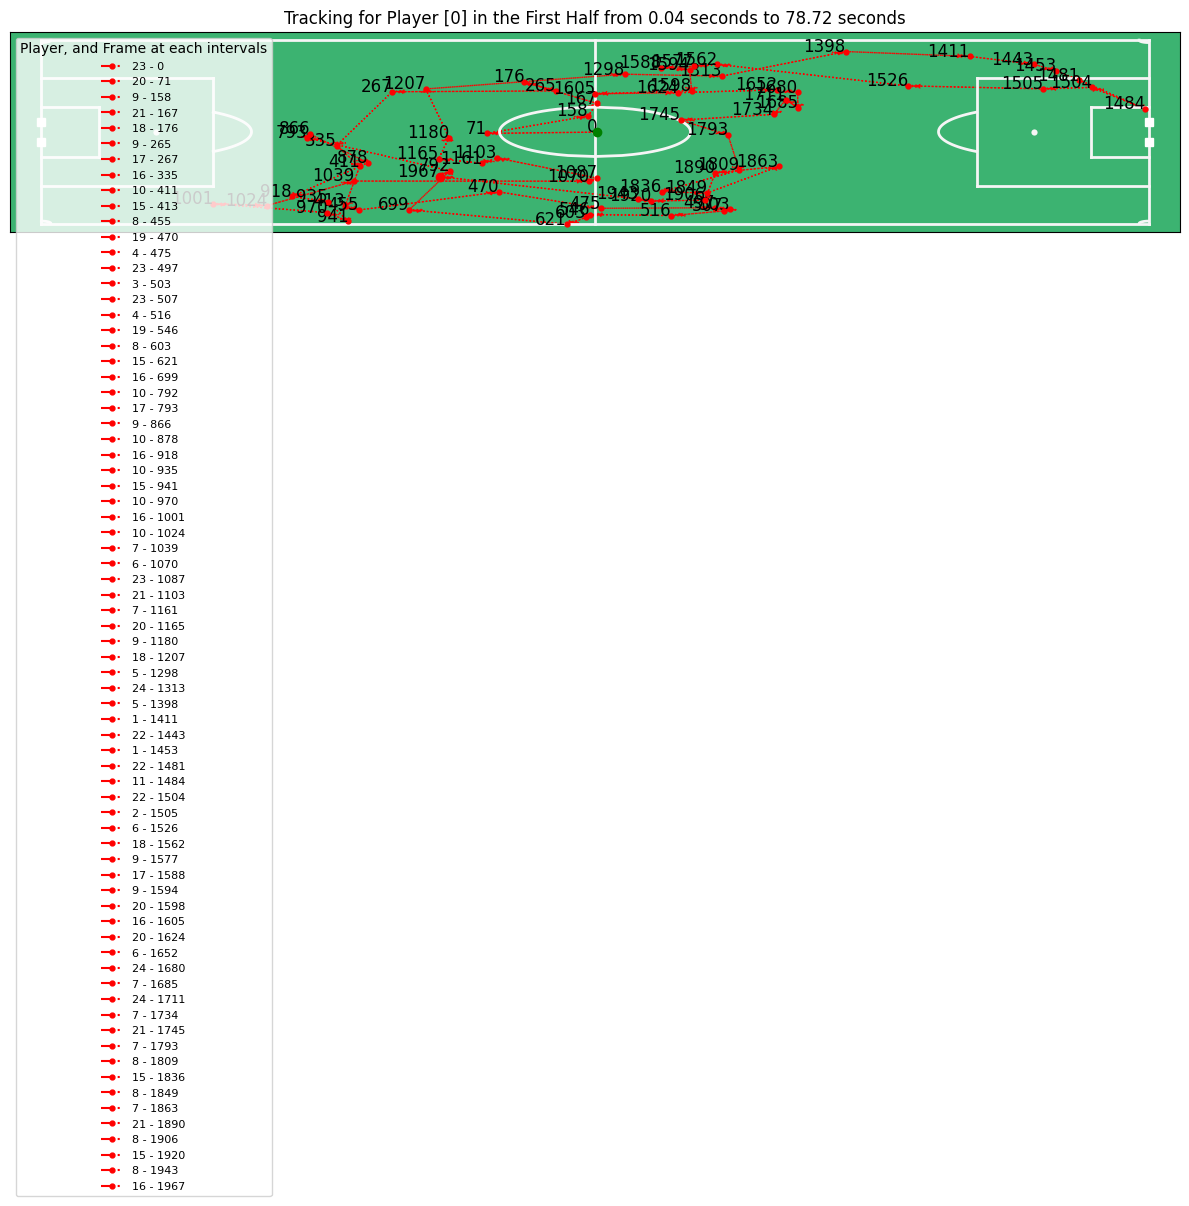

In [358]:
player_tracking(dif_min_dist_to_ball, plot_ball=False, players=[0], use_annotation=dif_player_col, sides=["Home"]) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Events that can happen during a match
- BALL LOST ['CLEARANCE', 'CROSS-INTERCEPTION', 'FORCED', 'FORCED-END HALF', 'GOAL KICK-INTERCEPTION', 'HEAD', 'HEAD-INTERCEPTION', 'INTERCEPTION', 'OFFSIDE', 'THEFT']

- BALL OUT ['CLEARANCE', 'HEAD']

- CARD ['YELLOW']

- CHALLENGE ['AERIAL-FAULT-LOST', 'AERIAL-FAULT-WON', 'AERIAL-LOST', 'AERIAL-WON', 'FAULT-WON', 'GROUND', 'GROUND-ADVANTAGE-LOST', 'GROUND-ADVANTAGE-WON', 'GROUND-FAULT-LOST', 'GROUND-FAULT-WON', 'GROUND-LOST', 'GROUND-WON', 'TACKLE-ADVANTAGE-WON', 'TACKLE-FAULT-LOST', 'TACKLE-FAULT-WON', 'TACKLE-LOST', 'TACKLE-WON']

- PASS ['CROSS', 'DEEP BALL', 'GOAL KICK', 'HEAD']

- RECOVERY ['BLOCKED', 'INTERCEPTION', 'SAVED', 'THEFT']

- SET PIECE ['CORNER KICK', 'FREE KICK', 'KICK OFF', 'THROW IN']

- SHOT ['BLOCKED', 'HEAD-OFF TARGET-OUT', 'OFF TARGET-HEAD-OUT', 'OFF TARGET-OUT', 'ON TARGET-GOAL', 'ON TARGET-SAVED']


In [361]:
df_event = pd.read_csv("Sample_Game_2_RawEventsData.csv")
df_event

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [406]:
df_event_period_1 = df_event[df_event["Period"] == 1]
df_sub_type = df_event_period_1[["Type", "Subtype"]]
df_sub_type_group = df_sub_type.groupby(df_sub_type["Type"])
df_sub_type_group_lst = df_sub_type_group.agg(lambda x: list(pd.unique(x))).reset_index()

for i in range(df_sub_type_group_lst.shape[0]):
    type_name = df_sub_type_group_lst.loc[i, "Type"]
    subtype_list = df_sub_type_group_lst.loc[i, "Subtype"]
    print(f"Type: {type_name}", "Subtype: ")
    for subtype in subtype_list:
        print(f"{subtype}", end=", ")
    print("\n")

Type: BALL LOST Subtype: 
INTERCEPTION, HEAD-INTERCEPTION, HEAD, nan, THEFT, GOAL KICK-INTERCEPTION, OFFSIDE, CLEARANCE, CROSS-INTERCEPTION, FORCED, FORCED-END HALF, 

Type: BALL OUT Subtype: 
nan, HEAD, CLEARANCE, 

Type: CARD Subtype: 
YELLOW, 

Type: CHALLENGE Subtype: 
GROUND-LOST, GROUND-WON, AERIAL-WON, AERIAL-LOST, TACKLE-LOST, AERIAL-FAULT-WON, AERIAL-FAULT-LOST, TACKLE-WON, GROUND-FAULT-LOST, GROUND-FAULT-WON, GROUND-ADVANTAGE-LOST, GROUND-ADVANTAGE-WON, TACKLE-FAULT-LOST, TACKLE-FAULT-WON, TACKLE-ADVANTAGE-WON, GROUND, FAULT-WON, 

Type: FAULT RECEIVED Subtype: 
nan, 

Type: PASS Subtype: 
nan, HEAD, CROSS, DEEP BALL, GOAL KICK, 

Type: RECOVERY Subtype: 
INTERCEPTION, nan, THEFT, SAVED, BLOCKED, 

Type: SET PIECE Subtype: 
KICK OFF, THROW IN, FREE KICK, CORNER KICK, 

Type: SHOT Subtype: 
OFF TARGET-OUT, ON TARGET-GOAL, ON TARGET-SAVED, BLOCKED, HEAD-OFF TARGET-OUT, OFF TARGET-HEAD-OUT, 



In [417]:
df_sub_type_count = df_sub_type.groupby(["Type", "Subtype"]).size().reset_index(name="Count")
df_sub_type_count

,Type,Subtype,Count
0,BALL LOST,CLEARANCE,1
1,BALL LOST,CROSS-INTERCEPTION,3
2,BALL LOST,FORCED,1
3,BALL LOST,FORCED-END HALF,1
4,BALL LOST,GOAL KICK-INTERCEPTION,2
5,BALL LOST,HEAD,6
6,BALL LOST,HEAD-INTERCEPTION,7
7,BALL LOST,INTERCEPTION,63
8,BALL LOST,OFFSIDE,1
9,BALL LOST,THEFT,24


In [420]:
df_sub_type_group.count()

,Subtype
Type,
BALL LOST,109
BALL OUT,4
CARD,1
CHALLENGE,144
FAULT RECEIVED,0
PASS,24
RECOVERY,109
SET PIECE,35
SHOT,11
